In [1]:
import pandas as pd

recipe_mpr = pd.read_json('https://raw.githubusercontent.com/D3Mlab/Recipe-MPR/main/data/500QA.json', orient = 'records')

correct_recipes = (
    recipe_mpr
    .assign(
        aspect = lambda d: d.correctness_explanation.apply(lambda x: list(x.keys())),
        option_id = lambda d: d.options.apply(lambda x: list(x.keys())),
        option_text = lambda d: d.options.apply(lambda x: list(x.values()))
    )
    .explode(['option_id', 'option_text'])
    .assign(correct = lambda d: d.answer == d.option_id)
    [['query', 'aspect', 'option_text', 'correct']]
    .explode(['aspect'])
)

correct_recipes

,query,aspect,option_text,correct
0,I want to make a warm dish containing oysters,warm dish,Simple creamy oyster soup,True
0,I want to make a warm dish containing oysters,oysters,Simple creamy oyster soup,True
0,I want to make a warm dish containing oysters,warm dish,Seasoned salted crackers shaped like oysters,False
0,I want to make a warm dish containing oysters,oysters,Seasoned salted crackers shaped like oysters,False
0,I want to make a warm dish containing oysters,warm dish,Creamy clam chowder made with whole milk and b...,False
...,...,...,...,...
499,What's a good broccoli side dish I can make fo...,side dish,Beef paired with bacon entree,False
499,What's a good broccoli side dish I can make fo...,loves meat,Beef paired with bacon entree,False
499,What's a good broccoli side dish I can make fo...,broccoli,Broccoli cooked in the oven,False
499,What's a good broccoli side dish I can make fo...,side dish,Broccoli cooked in the oven,False


In [2]:
query_entailment_scores = (
    pd.read_json("query_entailment_probabilities.json")
    .explode(['labels', 'scores'])
    .convert_dtypes()
    .rename(columns = {'labels': 'query', 'scores': 'score', 'sequence': 'option_text'})
)

query_dense_scores = pd.read_csv("query_dense_scores.csv", index_col=0)

naive_scores = pd.concat([
    query_entailment_scores.assign(scorer = "entailment"),
    query_dense_scores.assign(scorer = "dense")
]).assign(query = lambda d: d['query'].str.replace(",", "").str.strip())

naive_scores

,option_text,query,score,scorer
0,Shrimp roasted with vegetables in a zesty Ital...,I would like a shrimp recipe and I'm trying to...,0.890444,entailment
1,Shrimp balls made with pork fat deep fried in oil,I would like a shrimp recipe and I'm trying to...,0.064985,entailment
2,Breaded shrimp with whole milk and creole seas...,I would like a shrimp recipe and I'm trying to...,0.755538,entailment
3,Cucumber sauce with fat-free yogurt and reduce...,I would like a shrimp recipe and I'm trying to...,0.001509,entailment
4,Healthy napa cabbage and green onion coleslaw ...,I would like a shrimp recipe and I'm trying to...,0.000727,entailment
...,...,...,...,...
499,Fish meat cooked on a grill / stovetop / oven,Would I be able to get a breakfast recipe with...,87.29185,dense
499,Fish meat cooked in a steamer,Would I be able to get a breakfast recipe with...,86.48791,dense
499,Fish meat prepared with swiss cheese,Would I be able to get a breakfast recipe with...,86.14812,dense
499,Seafood linguine recipe containing shrimp,Would I be able to get a breakfast recipe with...,87.56526,dense


In [3]:
aspect_entailment_scores = (
    pd.read_json("aspect_entailment_probabilities.json")
    .explode(['labels', 'scores'])
    .convert_dtypes()
    .rename(columns = {'labels': 'aspect', 'scores': 'score', 'sequence': 'option_text'})
)

aspect_dense_scores = pd.read_csv("aspect_dense_scores.csv", index_col=0)

aspect_scores = pd.concat([
    aspect_entailment_scores.assign(scorer = "entailment"),
    aspect_dense_scores.assign(scorer = "dense")
])

aspect_based_scores = (
    aspect_scores
    .merge(correct_recipes)
    .groupby(['query', 'option_text', 'correct', 'scorer'])
    ['score'].agg(['min', 'mean', 'max', 'prod'])
    .reset_index()
    .assign(query = lambda d: d['query'].str.replace(",", "").str.strip())
)

aspect_based_scores

,query,option_text,correct,scorer,min,mean,max,prod
0,I would like a shrimp recipe and I'm trying to...,Breaded shrimp with whole milk and creole seas...,False,dense,78.73851,87.211205,95.6839,7534.007717
1,I would like a shrimp recipe and I'm trying to...,Breaded shrimp with whole milk and creole seas...,False,entailment,0.393063,0.684382,0.975701,0.383512
2,I would like a shrimp recipe and I'm trying to...,Cucumber sauce with fat-free yogurt and reduce...,False,dense,79.52807,81.565485,83.6029,6648.777283
3,I would like a shrimp recipe and I'm trying to...,Cucumber sauce with fat-free yogurt and reduce...,False,entailment,0.000088,0.469659,0.93923,0.000083
4,I would like a shrimp recipe and I'm trying to...,Healthy napa cabbage and green onion coleslaw ...,False,dense,80.485855,82.051997,83.61814,6730.077491
...,...,...,...,...,...,...,...,...
4995,Would I be able to get a breakfast recipe with...,Fish meat cooked on a grill / stovetop / oven,True,entailment,0.000038,0.332678,0.995877,0.0
4996,Would I be able to get a breakfast recipe with...,Fish meat prepared with swiss cheese,False,dense,76.473854,83.894686,91.20494,585919.349625
4997,Would I be able to get a breakfast recipe with...,Fish meat prepared with swiss cheese,False,entailment,0.000449,0.333063,0.99408,0.000002
4998,Would I be able to get a breakfast recipe with...,Seafood linguine recipe containing shrimp,False,dense,79.51198,91.347897,98.965126,6191108254.798872


In [4]:
ranks = (
    naive_scores
    .merge(aspect_based_scores)
    .rename(columns = {'score': 'naive'})
    .melt(id_vars = ['query', 'option_text', 'scorer', 'correct'], var_name='method', value_name='score')
    .assign(rank = lambda d: d.groupby(['query', 'scorer', 'method'])['score'].rank(ascending=False).astype(int))  
    .query("correct")
)

ranks

,query,option_text,scorer,correct,method,score,rank
0,I would like a shrimp recipe and I'm trying to...,Shrimp roasted with vegetables in a zesty Ital...,entailment,True,naive,0.890444,1
5,Any ideas for a brunch that is easy to make in...,Pancakes with berries,entailment,True,naive,0.491241,1
10,Any ideas for dye-free green desserts for St P...,Sweet kiwi tart made from real kiwis,entailment,True,naive,0.03754,1
15,Any traditional hotpot ideas for the Chinese n...,Spicy hotpot broth with Sichuan chili peppers,entailment,True,naive,0.176816,1
20,At my job site I don't have any shade to store...,"Assorted nuts mix containing pecans, cashews, ...",entailment,True,naive,0.671657,4
...,...,...,...,...,...,...,...
24975,What's a treat I can make for myself with milk...,Peanut ice cream made from scratch using milk,dense,True,prod,590371.722559,2
24980,What's something that I can just warm up the n...,"Breakfast wrap with scrambled eggs, smoked bac...",dense,True,prod,6959.029655,2
24985,What's the most simple meal I can make using j...,Standard plain porridge,dense,True,prod,7033.473542,3
24990,Whats a marinade I could make to make my ribey...,Ribeye steak marinade,dense,True,prod,917524.616942,1


In [5]:
(
    ranks
    .groupby(['scorer', 'method'])
    ['rank']
    .value_counts(normalize = True)
    .unstack()
    .round(2)
)

rank                  1     2     3     4     5
scorer     method                              
dense      max     0.27  0.25  0.22  0.16  0.09
           mean    0.32  0.25  0.21  0.13  0.08
           min     0.36  0.20  0.18  0.13  0.12
           naive   0.31  0.23  0.20  0.15  0.10
           prod    0.31  0.24  0.21  0.15  0.09
entailment max     0.37  0.25  0.21  0.11  0.06
           mean    0.68  0.15  0.10  0.04  0.03
           min     0.71  0.15  0.08  0.04  0.02
           naive   0.69  0.18  0.09  0.02  0.02
           prod    0.73  0.13  0.09  0.03  0.02

In [6]:
def mrr(ranks):
    # Mean reciprocal rank, higher is better
    return (1 / ranks).mean()

mrr_results = (
    ranks
    .assign(rr = lambda d: 1 / d['rank'])
    .groupby(['method', 'scorer'])
    ['rr'].agg(['mean', 'std'])
    .reset_index()
)

mrr_results.head()

,method,scorer,mean,std
0,max,dense,0.531567,0.302595
1,max,entailment,0.602233,0.316594
2,mean,dense,0.568133,0.313543
3,mean,entailment,0.805267,0.292362
4,min,dense,0.582900,0.329317


In [7]:
accuracy_results = (
    ranks
    .assign(accurate = lambda d: d['rank'] == 1)
    .groupby(['method', 'scorer'])
    ['accurate'].mean()
    .reset_index()
)

accuracy_results

,method,scorer,accurate
0,max,dense,0.272
1,max,entailment,0.368
2,mean,dense,0.324
3,mean,entailment,0.682
4,min,dense,0.364
5,min,entailment,0.706
6,naive,dense,0.312
7,naive,entailment,0.690
8,prod,dense,0.312
9,prod,entailment,0.728


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RecipeMPR Results MRR.png


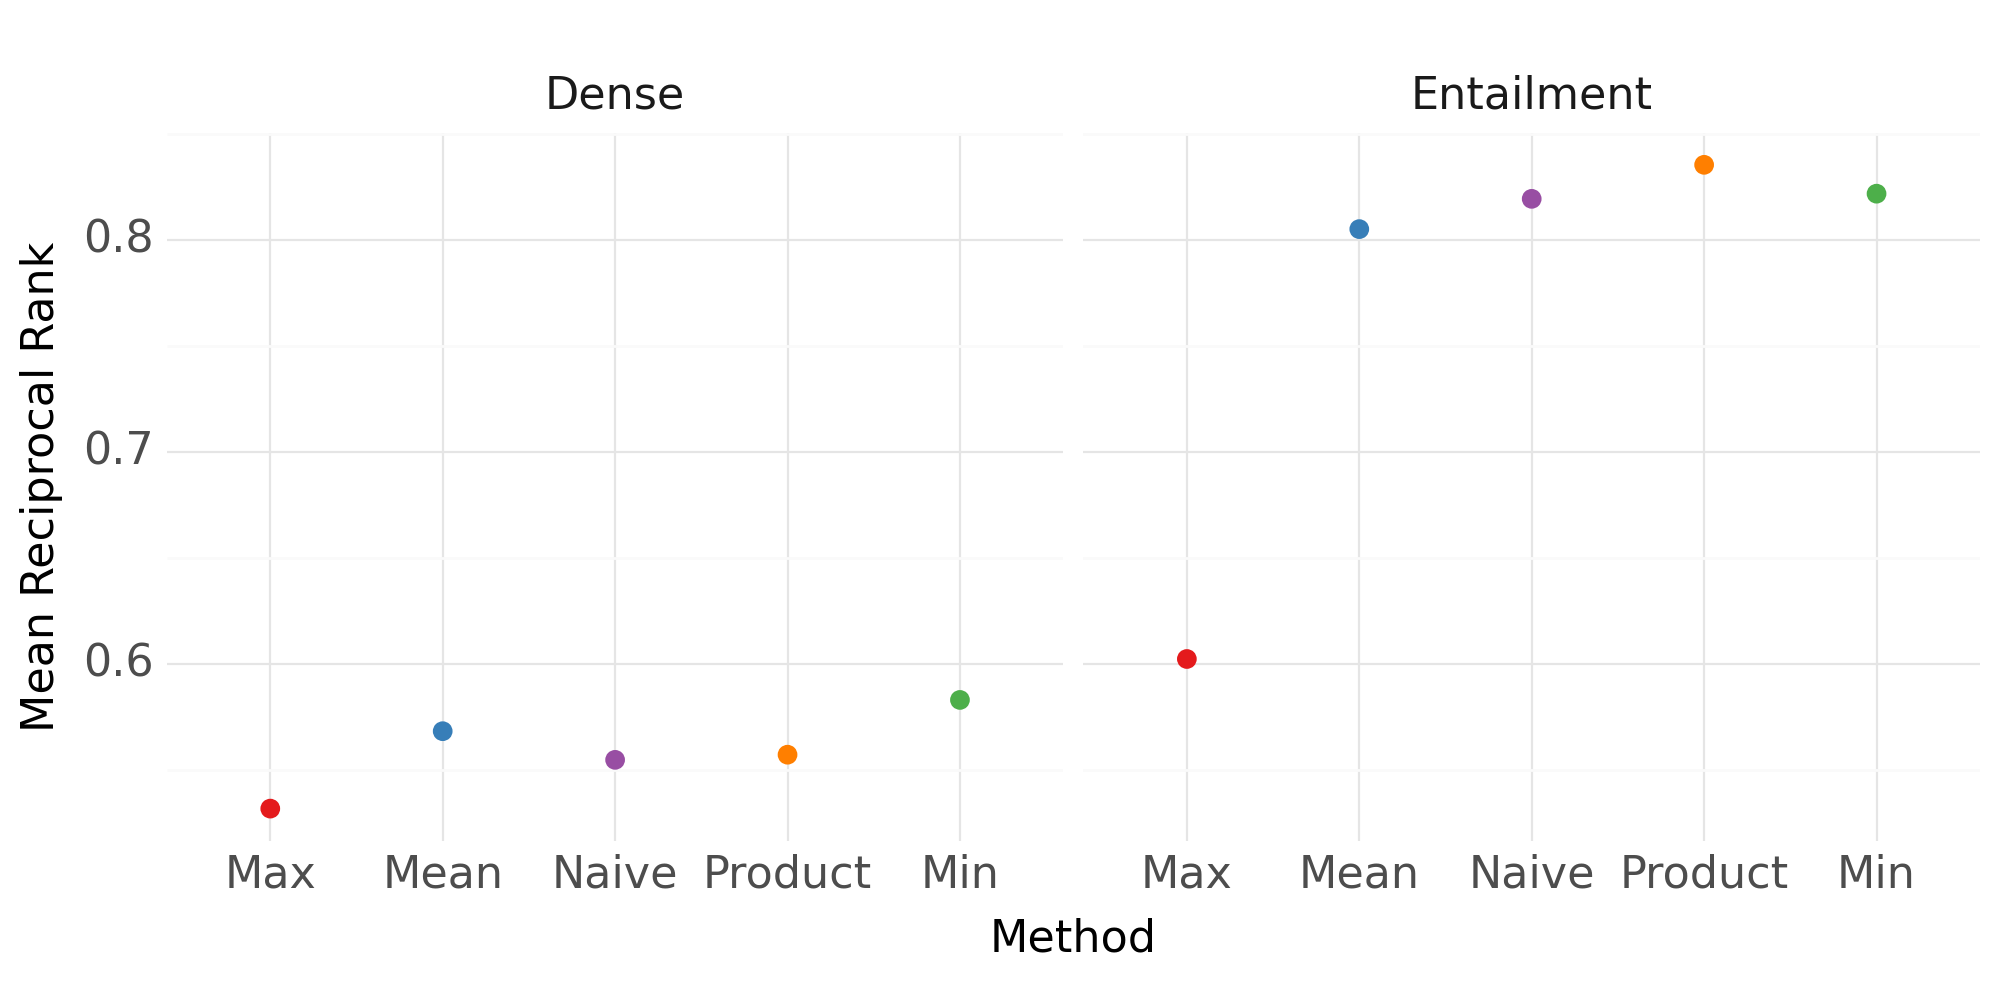

<Figure Size: (1000 x 500)>

In [8]:
from plotnine import *

p = (
    mrr_results
    .assign(
        method = lambda d: d.method.replace({'prod': 'product'}).str.capitalize(),
        scorer = lambda d: d.scorer.str.capitalize()
    )
    .pipe(ggplot, aes(y = 'mean', x = 'reorder(method, mean)', group = 'scorer', color = 'method')) +
    facet_wrap("scorer", scales = "free_x") +
    geom_point(size = 3) +
    theme_minimal() +
    scale_color_brewer(type="qual", palette="Set1") +
    labs(y = "Mean Reciprocal Rank", x = "Method", color = "", linetype="") +
    theme(figure_size=(10, 5), text=element_text(size=16), legend_entry_spacing_y=16, legend_position="none")
)

p.save("RecipeMPR Results MRR.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RecipeMPR Results Mean.png


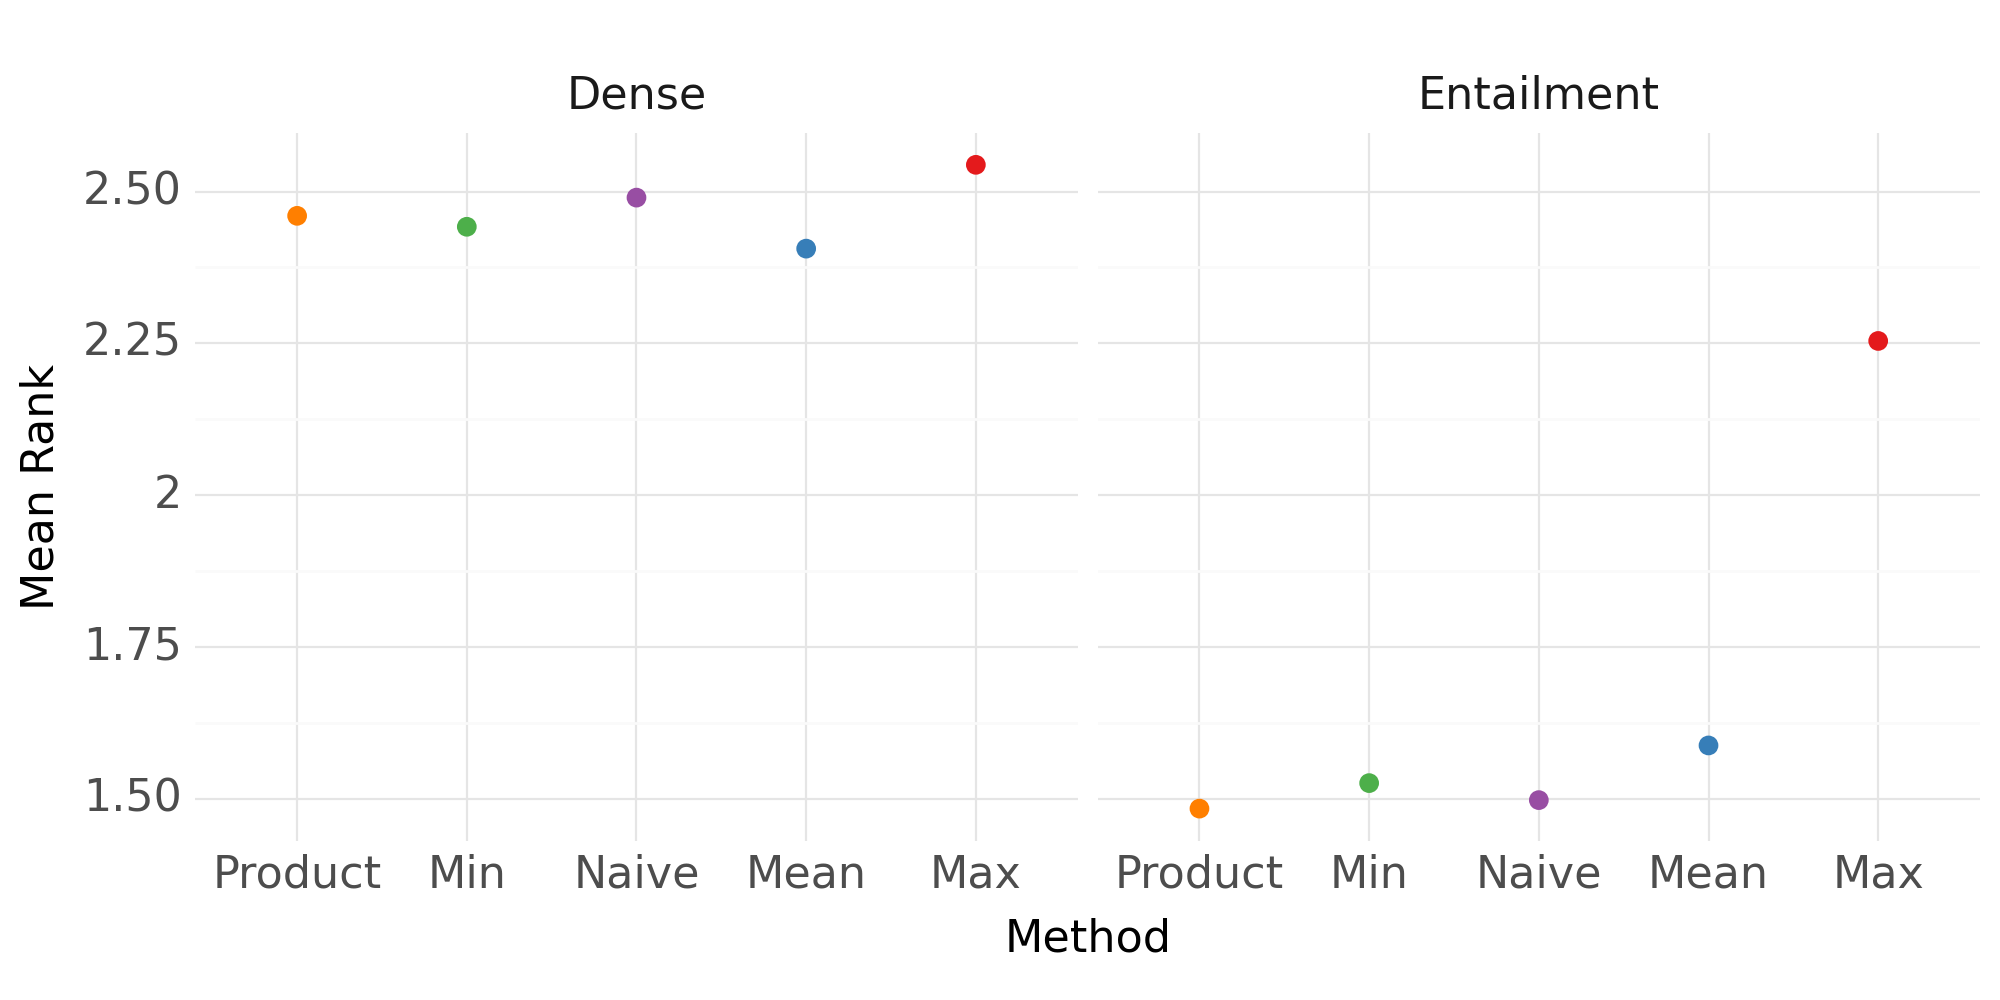

<Figure Size: (1000 x 500)>

In [9]:
p = (
    ranks
    .groupby(['method', 'scorer'])
    ['rank'].agg('mean')
    .reset_index()
    .assign(
        method = lambda d: d.method.replace({'prod': 'product'}).str.capitalize(),
        scorer = lambda d: d.scorer.str.capitalize()
    )
    .pipe(ggplot, aes(y = 'rank', x = 'reorder(method, rank)', group = 'scorer', color = 'method')) +
    facet_wrap("scorer", scales = "free_x") +
    geom_point(size = 3) +
    theme_minimal() +
    scale_color_brewer(type="qual", palette="Set1") +
    labs(y = "Mean Rank", x = "Method", color = "", linetype="") +
    theme(figure_size=(10, 5), text=element_text(size=16), legend_entry_spacing_y=16, legend_position="none")
)

p.save("RecipeMPR Results Mean.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RecipeMPR Results.png


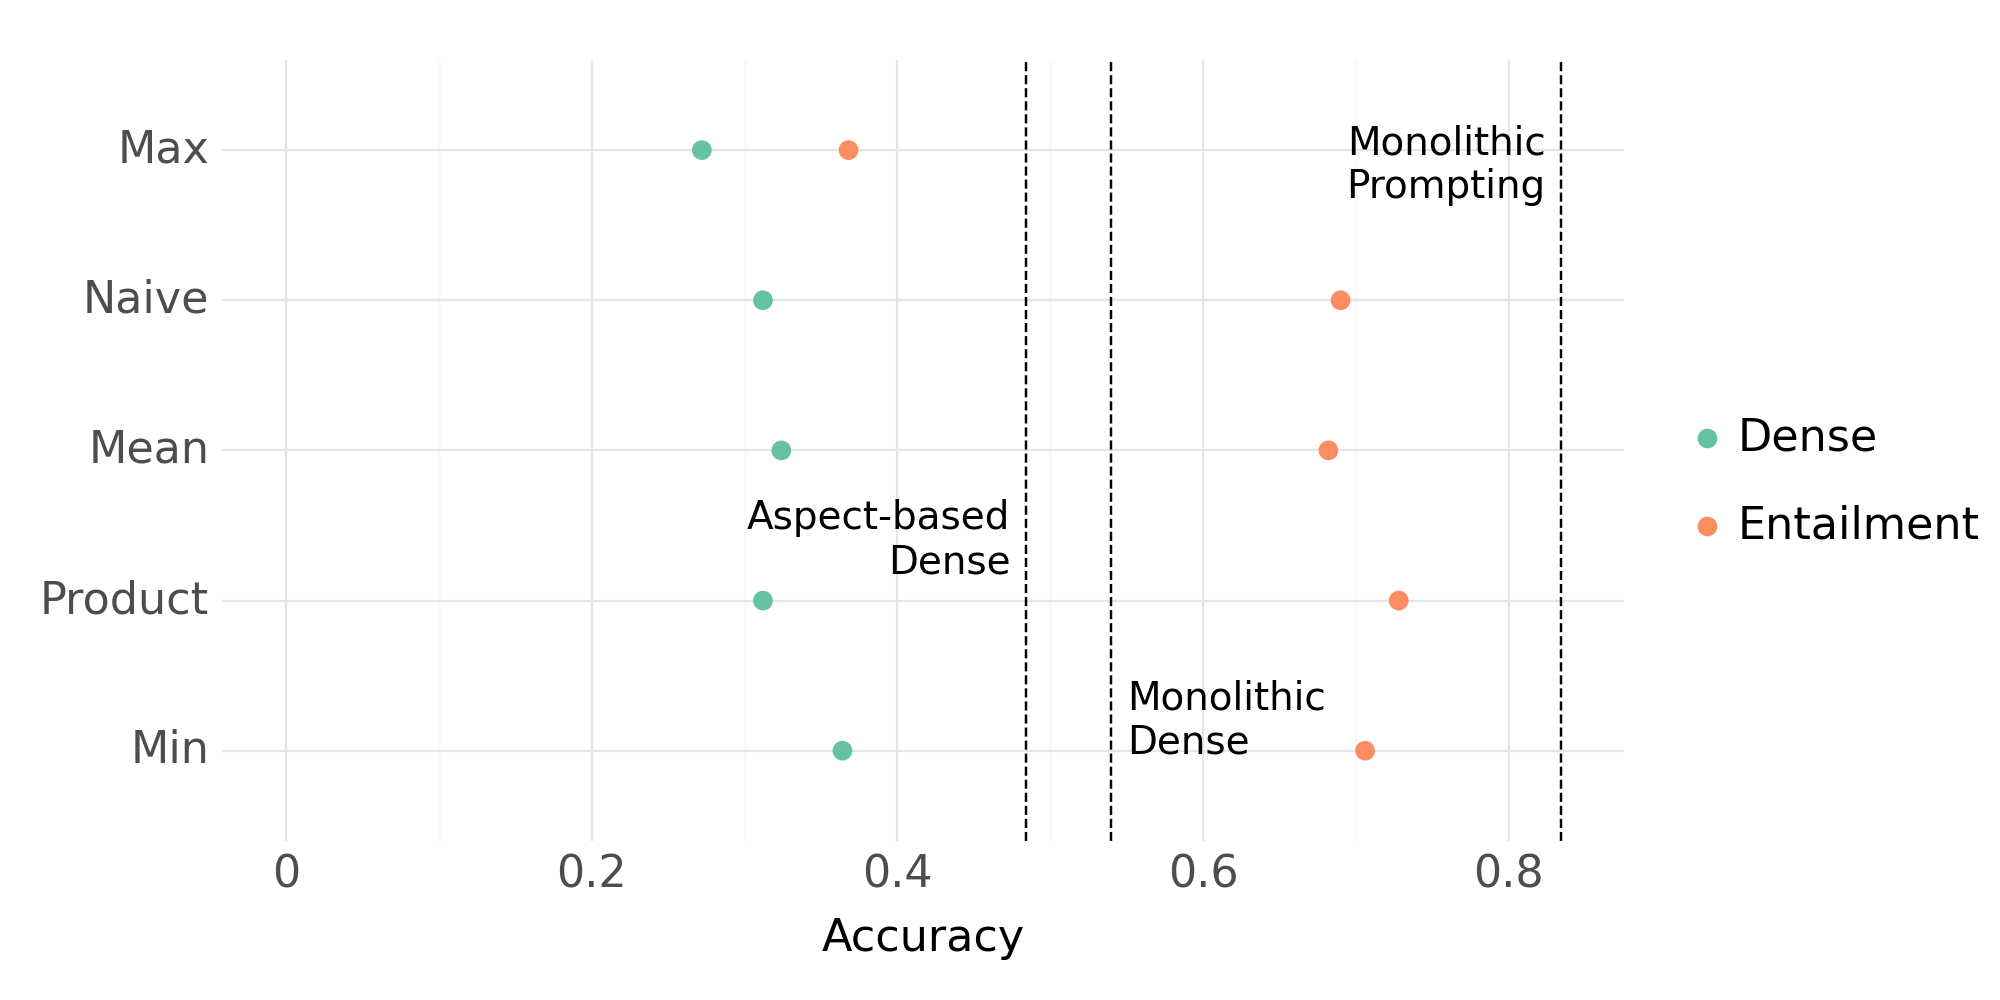

<Figure Size: (1000 x 500)>

In [10]:
from plotnine import *

p = (
    accuracy_results
    .assign(
        method = lambda d: d.method.replace({'prod': 'product'}).str.capitalize(),
        scorer = lambda d: d.scorer.str.capitalize()
    )
    .pipe(ggplot, mapping = aes(y = 'reorder(method, -accurate)', x = 'accurate', color = 'scorer')) +
    geom_vline(xintercept = 0.484, linetype = "--") +
    geom_vline(xintercept = 0.54, linetype = "--") +
    geom_vline(xintercept = 0.834, linetype = "--") +
    geom_point(size = 3) +
    theme_minimal() +
    labs(y = "", x = "Accuracy", color = "") +
    xlim(0, None) +
    scale_color_brewer(type = "qual", palette = "Set2") +
    theme(figure_size=(10, 5), text=element_text(size=16), legend_entry_spacing_y=16) +
    annotate(geom="text", x=0.55, y=1.2, label="Monolithic\nDense", ha = "left", size = 14) +
    annotate(geom="text", x=0.824, y=4.9, label="Monolithic\nPrompting", ha = "right", size = 14) +
    annotate(geom="text", x=0.474, y=2.4, label="Aspect-based\nDense", ha = "right", size = 14)
)

p.save("RecipeMPR Results.png")

p

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 5 in image.
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: RecipeMPR Results Ranks.png


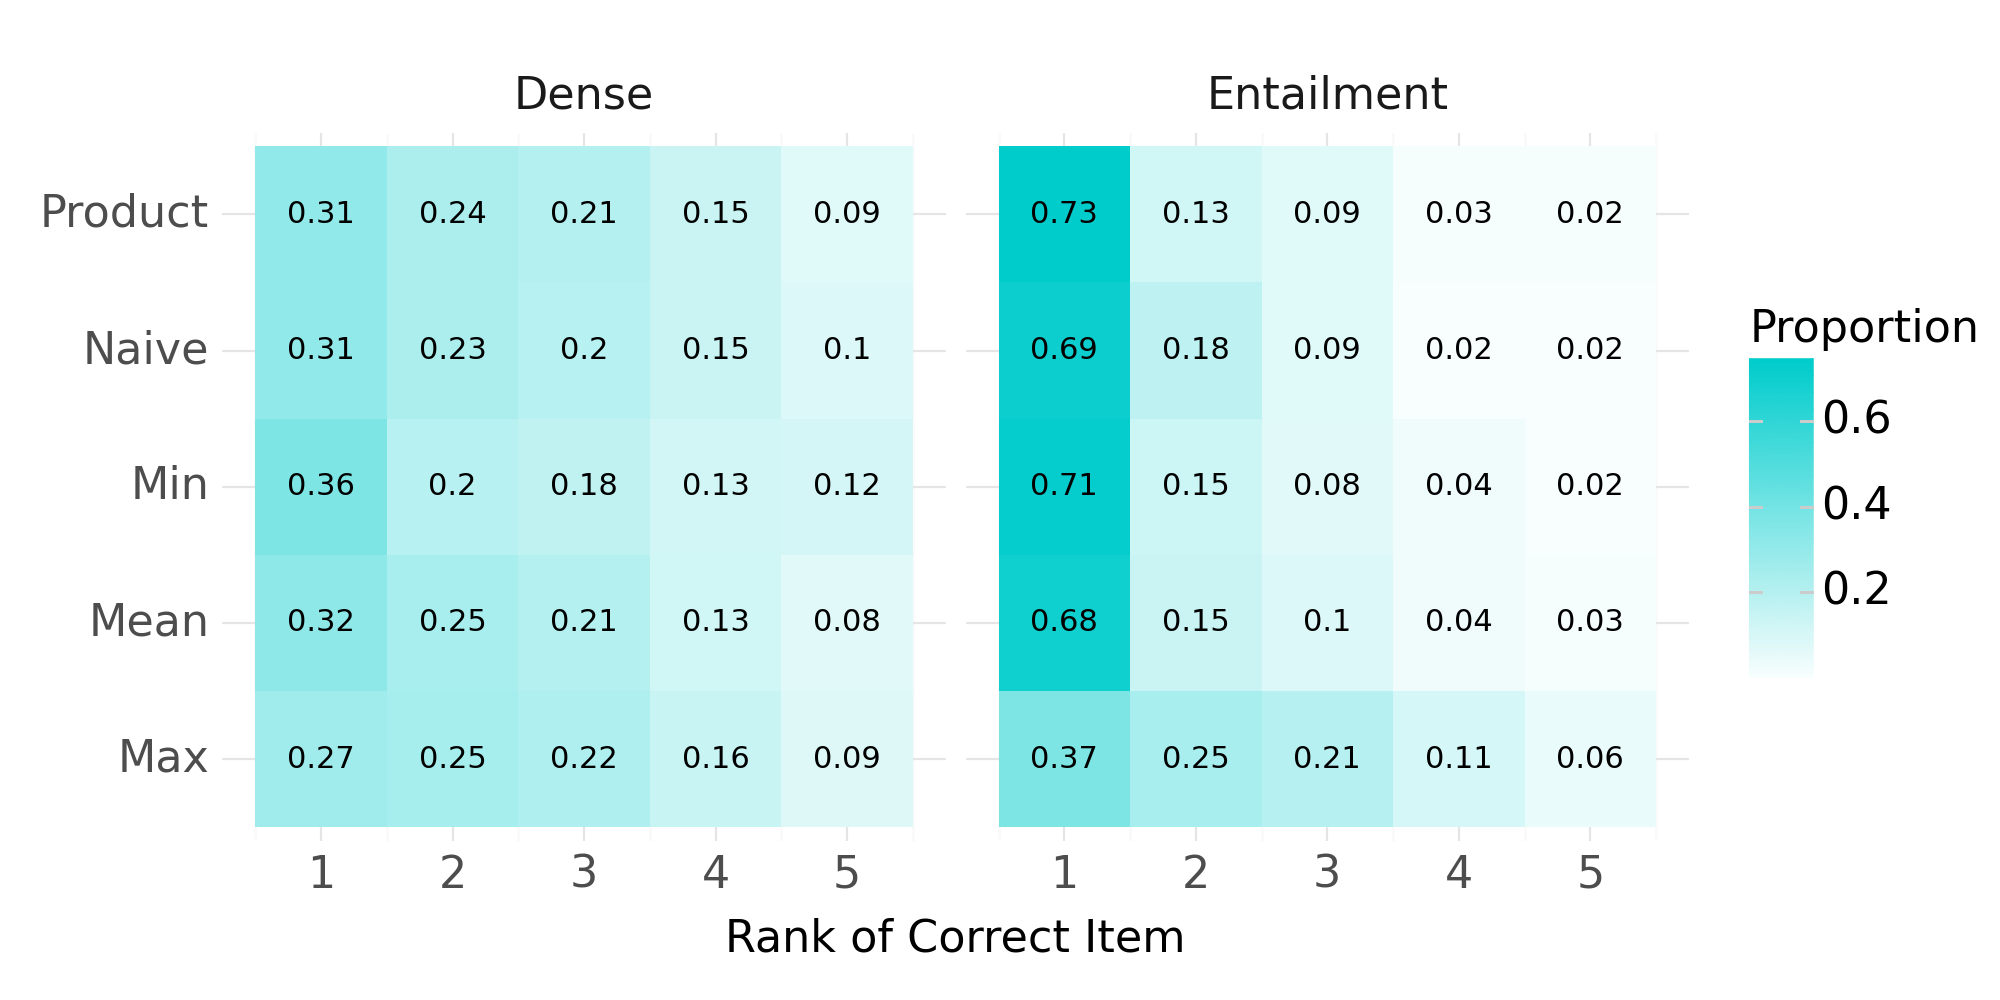

<Figure Size: (1000 x 500)>

In [11]:
p = (
    ranks
    .groupby(['scorer', 'method'])
    ['rank']
    .value_counts(normalize = True)
    .reset_index()
    .assign(
        method = lambda d: d.method.replace({'prod': 'product'}).str.capitalize(),
        scorer = lambda d: d.scorer.str.capitalize()
    )
    .pipe(ggplot, aes(x = 'rank', fill = 'proportion', y='method', label = "round(proportion, 2)")) +
    facet_wrap("scorer", scales = "free_x") +
    geom_tile() +
    geom_text() +
    theme_minimal() +
    scale_fill_gradient2(low = "white", high = "#00CCCC") +
    labs(y = "", x = "Rank of Correct Item", fill = "Proportion") +
    theme(figure_size=(10, 5), text=element_text(size=16))
)

p.save("RecipeMPR Results Ranks.png")

p